### This script shows a basic example of training a SentenceTransformer multimodal model with omics data stored in anndata format

In [3]:
from mmcontext.utils import setup_logging

setup_logging()

/Users/mengerj/repos/mmcontext/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/mengerj/repos/mmcontext/.venv/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
/Users/mengerj/repos/mmcontext/.venv/lib/python3.10/site-packages/wordcloud/wordcloud.py:35: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/mengerj/repos/mmcontext/.venv/lib/python3.10/site-packages/wordcloud/stopwords' mode='r' encoding='UTF-8'>
  STOPWORDS = set(map(str.strip, open(os.path.join(FILE, 'stopwords')).readlines()))


<RootLogger root (INFO)>

In [4]:
from mmcontext.mmcontextencoder import MMContextEncoder

enc = MMContextEncoder(
    text_encoder_name="NeuML/pubmedbert-base-embeddings",
    adapter_hidden_dim=None,
    adapter_output_dim=2048,
    output_token_embeddings=False,
    freeze_text_encoder=True,
    unfreeze_last_n_layers=1,
    train_lookup=False,
    joint_adapter_hidden_dim=None,
    text_model_kwargs=None,
    use_text_adapter=True,
)

2025-10-23 12:53:30,355 - mmcontext.mmcontextencoder - INFO - Unfreezing last 1 layers of BERT-like model
2025-10-23 12:53:30,356 - mmcontext.mmcontextencoder - INFO - Successfully unfroze 1 layers with 7087872 trainable parameters


In [5]:
from sentence_transformers import SentenceTransformer

modules = [enc]
model = SentenceTransformer(modules=modules)

2025-10-23 12:53:30,729 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps


In [6]:
import scanpy as sc

adata = sc.datasets.pbmc3k_processed()

In [7]:
import pybiomart

species = "hsapiens"
dataset = pybiomart.Dataset(name=f"{species}_gene_ensembl", host="http://www.ensembl.org")
biomart_df = dataset.query(attributes=["ensembl_gene_id", "external_gene_name"])

# Drop duplicates so that each gene symbol maps to exactly one Ensembl ID
biomart_df = biomart_df.drop_duplicates(subset="Gene name").set_index("Gene name")

# Prepare list for the mapped Ensembl IDs
gene_symbols = adata.var_names
ensembl_ids = []
for symbol in gene_symbols:
    if symbol in biomart_df.index:
        ensembl_ids.append(biomart_df.loc[symbol, "Gene stable ID"])
    else:
        ensembl_ids.append("")

In [8]:
adata.var["gene_names"] = adata.var_names
adata.var_names = ensembl_ids
# remove gene where indices dont start with ENS
adata = adata[:, adata.var.index.str.startswith("ENS")]

In [11]:
# Add gs10k embeddings directly to adata.obsm
model[0].add_gs10k_embeddings_to_adata(adata)
print(adata.obsm["gs10k"].shape)

2025-10-23 12:54:29,995 - mmcontext.gene_selection - INFO - Initialized GeneSelectEmbedder with gene_list_path: /Users/mengerj/repos/mmcontext/src/mmcontext/resources/gene_selection_10k.txt
2025-10-23 12:54:29,996 - mmcontext.gene_selection - INFO - Loading gene list from resources...
2025-10-23 12:54:29,998 - mmcontext.gene_selection - INFO - Loaded 10000 genes from /Users/mengerj/repos/mmcontext/src/mmcontext/resources/gene_selection_10k.txt
2025-10-23 12:54:29,998 - mmcontext.gene_selection - INFO - GeneSelect embedder prepared. Gene set contains 10000 genes.
2025-10-23 12:54:29,999 - mmcontext.mmcontextencoder - INFO - Generating gene-selected embeddings for 2638 cells using 10000 genes
2025-10-23 12:54:29,999 - mmcontext.gene_selection - INFO - Applying gene selection using scVI foundation model gene set...
2025-10-23 12:54:30,070 - mmcontext.gene_selection - WARNING - Dataset missing 9302 genes, filled with zeros
2025-10-23 12:54:30,071 - mmcontext.gene_selection - INFO - Dataset

(2638, 10000)


In [12]:
# Create token DataFrame from any obsm key
token_df = model[0].create_token_dataframe_from_obsm(adata, obsm_key="gs10k")

2025-10-23 12:54:37,352 - mmcontext.mmcontextencoder - INFO - Created token DataFrame from adata.obsm['gs10k'] with shape: (2638, 2)
2025-10-23 12:54:37,354 - mmcontext.mmcontextencoder - INFO - Each embedding has dimension: 10000
2025-10-23 12:54:37,356 - mmcontext.mmcontextencoder - INFO - Use the returned DataFrame to register the embeddings with `register_initial_embeddings()`.


In [13]:
model[0].register_initial_embeddings(token_df, data_origin="gs10k")

2025-10-23 12:54:44,453 - mmcontext.omicsencoder - INFO - Loaded embedding matrix with shape (2639, 10000)
2025-10-23 12:54:44,454 - mmcontext.mmcontextencoder - INFO - Registered 2639 new numeric samples (total 2639). ≈0.098 GiB added. (Assuming float32 precision.)


In [17]:
# The processor knows a certain prefix, which has to be added to the beginning of a text input
# Then this text input is treated with the omics tokenizer
prefix = model[0].processor.prefix
# take the obs ids from the adata object, add the prefix to each and store as a list of strings
obs_ids = adata.obs_names.tolist()
obs_ids = [prefix + id for id in obs_ids]
# The model can now be used to encode the obs_ids
obs_ids

['sample_idx:AAACATACAACCAC-1',
 'sample_idx:AAACATTGAGCTAC-1',
 'sample_idx:AAACATTGATCAGC-1',
 'sample_idx:AAACCGTGCTTCCG-1',
 'sample_idx:AAACCGTGTATGCG-1',
 'sample_idx:AAACGCACTGGTAC-1',
 'sample_idx:AAACGCTGACCAGT-1',
 'sample_idx:AAACGCTGGTTCTT-1',
 'sample_idx:AAACGCTGTAGCCA-1',
 'sample_idx:AAACGCTGTTTCTG-1',
 'sample_idx:AAACTTGAAAAACG-1',
 'sample_idx:AAACTTGATCCAGA-1',
 'sample_idx:AAAGAGACGAGATA-1',
 'sample_idx:AAAGAGACGCGAGA-1',
 'sample_idx:AAAGAGACGGACTT-1',
 'sample_idx:AAAGAGACGGCATT-1',
 'sample_idx:AAAGCAGATATCGG-1',
 'sample_idx:AAAGCCTGTATGCG-1',
 'sample_idx:AAAGGCCTGTCTAG-1',
 'sample_idx:AAAGTTTGATCACG-1',
 'sample_idx:AAAGTTTGGGGTGA-1',
 'sample_idx:AAAGTTTGTAGAGA-1',
 'sample_idx:AAAGTTTGTAGCGT-1',
 'sample_idx:AAATCAACAATGCC-1',
 'sample_idx:AAATCAACACCAGT-1',
 'sample_idx:AAATCAACCAGGAG-1',
 'sample_idx:AAATCAACCCTATT-1',
 'sample_idx:AAATCAACGGAAGC-1',
 'sample_idx:AAATCAACTCGCAA-1',
 'sample_idx:AAATCATGACCACA-1',
 'sample_idx:AAATCCCTCCACAA-1',
 'sample

In [36]:
omics_embeddings = model.encode(obs_ids)
adata.obsm["mmcontext_emb"] = omics_embeddings

Batches: 100%|██████████| 83/83 [00:00<00:00, 183.83it/s]


In [35]:
del adata.obsp
del adata.varm
del adata.uns
del adata.obsm

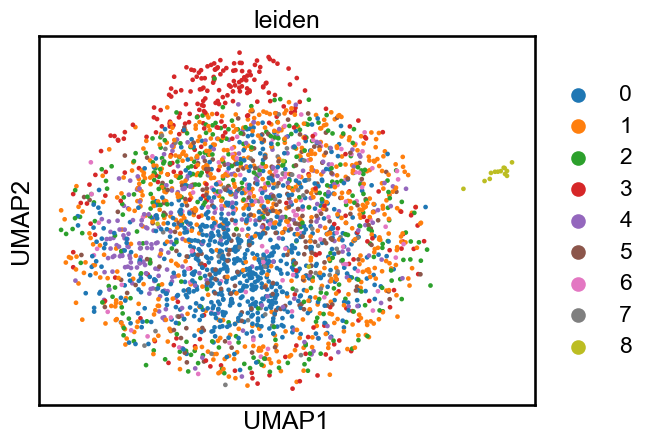

In [ ]:
# To perform clustering and visualization on the mmcontext_emb embedding,
# specify it as the basis for the neighbors and UMAP calculations via the 'use_rep' argument.
# This ensures the workflow uses your custom embedding from adata.obsm["mmcontext_emb"].

# Compute neighbors using the mmcontext_emb embedding
sc.pp.neighbors(adata, use_rep="mmcontext_emb")

# Perform Leiden clustering
sc.tl.leiden(adata, key_added="leiden")

# Compute UMAP based on the same embedding
sc.tl.umap(adata)

# Visualize clusters
sc.pl.umap(
    adata,
    color="leiden",
)